In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
# import pandas as pd
import matplotlib.pyplot as plt

In [2]:
torch.__version__

'1.3.1+cu100'

In [3]:
torch.cuda.is_available()

True

In [4]:
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    # transforms.RandomCrop(128),
    transforms.ToTensor()])

cba_train = torchvision.datasets.CelebA('~', download=True, split='train', transform=transform, target_transform=lambda x: x.float())
cba_test = torchvision.datasets.CelebA('~', download=True, split='test', transform=transform, target_transform=lambda x: x.float())

Files already downloaded and verified
Files already downloaded and verified


In [0]:
train_loader = torch.utils.data.DataLoader(cba_train, batch_size=64, shuffle=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(cba_test, batch_size=64, shuffle=False, pin_memory=True)

In [0]:
def print_attrs(attr, celebA_dataset):
    legible = ''
    for i, a in enumerate(list(attr)):
        if a == 1:
            legible += celebA_dataset.attr_names[i] + ", "
    return legible

'5_o_Clock_Shadow, Attractive, Male, Mouth_Slightly_Open, No_Beard, Smiling, Straight_Hair, Wearing_Necktie, Young, '

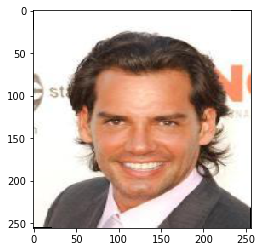

In [7]:
loaderit = iter(train_loader)
img, attr = next(loaderit)
plt.imshow(img[0,:,:,:].permute(1,2,0))
print_attrs(attr[0,:], cba_train)

In [8]:
img.shape, img.min(), img.max(), attr.shape

(torch.Size([64, 3, 256, 256]), tensor(0.), tensor(1.), torch.Size([64, 40]))

In [9]:
attr.dtype

torch.float32

In [0]:
# 3x3 convolution: from https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/deep_residual_network/main.py
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block: from https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/deep_residual_network/main.py
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, residual_op=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.residual_op = residual_op
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.residual_op:
            residual = self.residual_op(x)
        out += residual
        out = self.relu(out)
        return out

# Follows elements of https://github.com/pytorch/examples/blob/master/vae/main.py
class AutoEncoder(nn.Module):
    def __init__(self, latent_dim = 100, condition_dim = 40):
        super().__init__()
        self.latent_dim = latent_dim
        self.condition_dim = condition_dim
        
        # first layer of ResNet
        self.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.bn1 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False) 

        # first encoding block
        self.layer1 = nn.Sequential(
            ResidualBlock(64, 64),
            ResidualBlock(64, 64),
            ResidualBlock(64, 64)
        )

        # second encoding block
        self.resid1 = nn.Sequential(conv3x3(64, 128), nn.BatchNorm2d(128))
        self.layer2 = nn.Sequential(
            ResidualBlock(64, 128, residual_op = self.resid1),
            ResidualBlock(128, 128),
            ResidualBlock(128, 128),
        )

        # reduce dimension with average pool
        self.avgpool = nn.AvgPool2d(kernel_size = 3, stride = 2, padding = 1, ceil_mode = False)

        # projecting the last feature map into latent space (linear)
        self.flat = nn.Flatten()
        self.mu_latent = nn.Linear(128 * 32 * 32, self.latent_dim)
        self.sig_latent = nn.Linear(128 * 32 * 32, self.latent_dim)

        # projecting out of latent space (non-linear)
        self.project_z = nn.Sequential(
            nn.Linear(self.latent_dim + self.condition_dim, 64 * 64),
            self.relu,
        )
        
        # first decoding block
        self.decode1 = nn.Sequential(
            ResidualBlock(1, 64),
            ResidualBlock(64, 64),
            ResidualBlock(64, 64),
            nn.Upsample(scale_factor = (2,2)),
        )

        # second decoding block
        self.resid2 = nn.Sequential(conv3x3(64, 32), nn.BatchNorm2d(32))
        self.decode2 = nn.Sequential(
            ResidualBlock(64, 32, residual_op = self.resid2), 
            ResidualBlock(32, 32),
            ResidualBlock(32, 32),
            nn.Upsample(scale_factor = (2,2)),
        )

        # final decoding block
        self.resid3 = nn.Sequential(conv3x3(32, 3), nn.BatchNorm2d(3))
        self.decode3 = nn.Sequential(
            ResidualBlock(32, 3, residual_op = self.resid3),
            ResidualBlock(3, 3),
            ResidualBlock(3, 3),
        )

    def reparameterize(self, mu, std):
        """ 
        # previous reference to `sig` is really log variance, used for numerical stability
        here make conversion and apply the reparameterization trick, i.e. N(mu, sig) = mu + N(0, 1) * sig
        """
        # std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def encode(self, x):
        out = self.conv1(x)     # stride 2: reduce dim by 2x
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out) # stride 2: reduce dim by 2x
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.avgpool(out) # stride 2: reduce dim by 2x
        out = self.flat(out)
        mu = self.mu_latent(out)
        sig = self.sig_latent(out)
        return mu, sig
    
    def decode(self, z):
        # latent space operations: project + reshape
        zout = self.project_z(z)
        batch_size, new_dim = int(zout.shape[0]), int(np.sqrt(zout.shape[1]))
        zout = zout.view(batch_size, 1, new_dim, new_dim) # reshape to be "image-like"

        # decoding layers
        out = self.decode1(zout)
        out = self.decode2(out)
        out = self.decode3(out)
        out = torch.sigmoid(out) # sigmoid because pixel values in (0, 1)
        return out

    def forward(self, x, attr):
        # encoding
        mu, sig = self.encode(x)

        # operations in latent space: sample + concat attributes
        z = self.reparameterize(mu, sig)
        z_cond = torch.cat((z, attr), 1) # add attributes to z

        # decoding
        out = self.decode(z_cond)

        return out, mu, sig

In [0]:
mse_loss = torch.nn.MSELoss().cuda()

# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, sig):
    # BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    RECON = mse_loss(recon_x, x)
    # print(RECON)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - torch.exp(logvar))
    KLD = -0.5 * torch.sum(1 + torch.log(sig.pow(2)) - mu.pow(2) - sig.pow(2))
    # print(KLD)

    return RECON + KLD

In [ ]:
torch.manual_seed(42)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

ae = AutoEncoder().to(device)

optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3)
lr_schedule = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95)

# Train the model
num_epochs = 10
total_step = len(train_loader)
losses = []
for epoch in range(num_epochs):
    for i, (img, attr) in enumerate(train_loader):
        img = img.to(device)
        attr = attr.to(device)
        
        # Forward pass
        gen_img, mu, sig = ae(img, attr)
        loss = loss_function(gen_img, img, mu, sig)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        
        if (i+1) % 100  == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}".format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            fig, ax = plt.subplots(2,5,figsize=(20,6))
            for i, _ax in enumerate(ax[0,:]):
                _ax.imshow(img[i,:,:,:].permute(1,2,0).cpu())
                _ax.set_title('Original')
            for i, _ax in enumerate(ax[1,:]):
                _ax.imshow(gen_img[i, :, :, :].permute(1, 2, 0).cpu().detach())
                _ax.set_title('Generated')
            fig.tight_layout()
            plt.show()

    # Save the model checkpoint
    torch.save(ae.state_dict(), 'resnet_autoencoder.ckpt')
    
    # Step the learning rate
    lr_schedule.step()
    print('new LR = {}'.format(lr_schedule.get_lr()))